In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import NMF

import utils.sulfur.constant as const
from utils.CaImageCSV import CaImageCSV
from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer
from matching_score_resampling import MatchingScoreResampling

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
mc = MatchingScoreResampling()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd71cdd6da0ab5f91b96805ab7873f3e NOW.


In [3]:
def split_engram_matrix(animal_name, context_name):
    csv = ContextDataCSV(animal_name, context_name)
    matrix = csv.data_frame
    matrix = MatrixOptimizer(matrix).divide_sd()
    
    engram_df = matrix.loc[:, csv.engram_cells()]
    non_engram_df = matrix.loc[:, csv.non_engram_cells()]
    
    return engram_df, non_engram_df

def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

def split_matrix(matrix, context_name):
    matrix_1 = matrix.iloc[0:400, :]
    matrix_2 = matrix.iloc[900:1300, :]
    matrix_3 = matrix.iloc[1800:2200, :]
    
    return matrix_1, matrix_2, matrix_3

def AICc(distance, K, N):
    return 2 * distance + 2 * K * (N / (N - K - 1)) # 対数尤度=-Dis(x,y) より 

def setted_NMF(df, components_size):
    model = NMF(n_components=components_size, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu', max_iter=2000)
    model.fit(df)
    W = model.transform(df)
    H = model.components_
    
    return W, H, model

def calc_matching_score(base_pattern_vectors, comp_pattern_vectors):
    threshold = 0.6
    similarities = cosine_similarity(base_pattern_vectors, comp_pattern_vectors)
    matching_score = 0
    for similarity in similarities:
        if len(similarity[similarity > threshold]) > 0:
            matching_score += 1
        
    return matching_score / len(base_pattern_vectors)
    
def build_pattern_vectors(dfs):
    patterns = {}
    for context_name, df in dfs.items():
        min_aic_value = float('inf')
        min_H = None
        upper_count = 0
        
        for n in range(1, len(df.columns) + 1):
            _, H, model = setted_NMF(df, n)
            err = model.reconstruction_err_
            aic_value = AICc(err, n, len(columns) * len(df))
            if min_aic_value > aic_value:
                upper_count = 0
                min_aic_value = aic_value
                min_H = H
                
            if min_aic_value < aic_value:
                upper_count += 1
                
            if upper_count > 20:
                break
                
        patterns[context_name] = min_H
        
    return patterns

In [4]:
index = const.ANIMAL_NAMES
columns = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
engram_matching_score = pd.DataFrame(index=index, columns=columns)
non_engram_matching_score = pd.DataFrame(index=index, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    A1postES_engram, A1postES_non_engram = split_engram_matrix(animal_name, 'A1postES')
    A4postES_engram, A4postES_non_engram = split_engram_matrix(animal_name, 'A4postES')

    A1postES_nan_engram_cells = all_nan_cells(A1postES_engram)
    A1postES_nan_non_engram_cells = all_nan_cells(A1postES_non_engram)
    A4postES_nan_engram_cells = all_nan_cells(A4postES_engram)
    A4postES_nan_non_engram_cells = all_nan_cells(A4postES_non_engram)
    
    droped_engram_cells = droped_unique_cells(A1postES_nan_engram_cells, A4postES_nan_engram_cells)
    droped_non_engram_cells = droped_unique_cells(A1postES_nan_non_engram_cells, A4postES_nan_non_engram_cells)
    
    A1postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A1postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)

    A4postES_engram.drop(columns=droped_engram_cells, inplace=True)
    A4postES_non_engram.drop(columns=droped_non_engram_cells, inplace=True)
    
    engram_A1postES_1, engram_A1postES_2, engram_A1postES_3 = split_matrix(A1postES_engram, 'A1postES')
    engram_A4postES_1, engram_A4postES_2, engram_A4postES_3 = split_matrix(A4postES_engram, 'A4postES')

    non_engram_A1postES_1, non_engram_A1postES_2, non_engram_A1postES_3 = split_matrix(A1postES_non_engram, 'A1postES')
    non_engram_A4postES_1, non_engram_A4postES_2, non_engram_A4postES_3 = split_matrix(A4postES_non_engram, 'A4postES')
    
    engram_df = {}
    engram_df['A1_1'] = engram_A1postES_1
    engram_df['A1_2'] = engram_A1postES_2
    engram_df['A1_3'] = engram_A1postES_3
    engram_df['A4_1'] = engram_A4postES_1
    engram_df['A4_2'] = engram_A4postES_2
    engram_df['A4_3'] = engram_A4postES_3
    engram_patterns = build_pattern_vectors(engram_df)

    engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_1'])
    engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_2'])
    engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A1_3'])
    engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_1'])
    engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_2'])
    engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(engram_patterns['A1_1'], engram_patterns['A4_3'])

    non_engram_df = {}
    non_engram_df['A1_1'] = non_engram_A1postES_1
    non_engram_df['A1_2'] = non_engram_A1postES_2
    non_engram_df['A1_3'] = non_engram_A1postES_3
    non_engram_df['A4_1'] = non_engram_A4postES_1
    non_engram_df['A4_2'] = non_engram_A4postES_2
    non_engram_df['A4_3'] = non_engram_A4postES_3
    non_engram_patterns = build_pattern_vectors(non_engram_df)
    
    non_engram_matching_score.loc[animal_name, 'A1_1'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_1'])
    non_engram_matching_score.loc[animal_name, 'A1_2'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_2'])
    non_engram_matching_score.loc[animal_name, 'A1_3'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A1_3'])
    non_engram_matching_score.loc[animal_name, 'A4_1'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_1'])
    non_engram_matching_score.loc[animal_name, 'A4_2'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_2'])
    non_engram_matching_score.loc[animal_name, 'A4_3'] = calc_matching_score(non_engram_patterns['A1_1'], non_engram_patterns['A4_3'])
    
print(engram_matching_score)
print(non_engram_matching_score)

animal_name: ID181106CreA


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


animal_name: ID181106CreB
animal_name: ID181106CreC
animal_name: ID181106CreG


/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


animal_name: ID181106CreH
animal_name: ID181106CreI
animal_name: ID181106CreK
animal_name: ID181106CreL
animal_name: ID181106CreN
animal_name: ID181106CreQ
             A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  1.0  0.769231  0.846154  0.884615  0.884615  0.884615
ID181106CreB  1.0  0.928571       1.0  0.857143  0.857143  0.928571
ID181106CreC  1.0       1.0  0.833333  0.833333  0.777778  0.944444
ID181106CreG  1.0  0.947368  0.947368  0.947368  0.894737  0.842105
ID181106CreH  1.0  0.764706  0.676471  0.764706  0.588235  0.647059
ID181106CreI  1.0   0.73913  0.521739  0.608696  0.391304  0.521739
ID181106CreK  1.0  0.761905  0.857143  0.857143       1.0  0.857143
ID181106CreL  1.0  0.866667       0.8  0.733333       0.8  0.666667
ID181106CreN  1.0       1.0     0.875    0.9375      0.75    0.9375
ID181106CreQ  1.0  0.941176  0.882353  0.823529  0.882353  0.764706
             A1_1      A1_2      A1_3      A4_1      A4_2      A4_3
ID181106CreA  1.0   0.22449 

In [5]:
engram_matching_score

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
ID181106CreA,1.0,0.769231,0.846154,0.884615,0.884615,0.884615
ID181106CreB,1.0,0.928571,1.0,0.857143,0.857143,0.928571
ID181106CreC,1.0,1.0,0.833333,0.833333,0.777778,0.944444
ID181106CreG,1.0,0.947368,0.947368,0.947368,0.894737,0.842105
ID181106CreH,1.0,0.764706,0.676471,0.764706,0.588235,0.647059
ID181106CreI,1.0,0.73913,0.521739,0.608696,0.391304,0.521739
ID181106CreK,1.0,0.761905,0.857143,0.857143,1.0,0.857143
ID181106CreL,1.0,0.866667,0.8,0.733333,0.8,0.666667
ID181106CreN,1.0,1.0,0.875,0.9375,0.75,0.9375
ID181106CreQ,1.0,0.941176,0.882353,0.823529,0.882353,0.764706


In [6]:
non_engram_matching_score

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
ID181106CreA,1.0,0.22449,0.183673,0.040816,0.0,0.020408
ID181106CreB,1.0,0.368421,0.421053,0.105263,0.026316,0.026316
ID181106CreC,1.0,0.457143,0.514286,0.257143,0.171429,0.257143
ID181106CreG,1.0,0.27907,0.418605,0.0,0.0,0.0
ID181106CreH,1.0,0.514286,0.542857,0.028571,0.142857,0.057143
ID181106CreI,1.0,0.466667,0.266667,0.166667,0.133333,0.166667
ID181106CreK,1.0,0.195122,0.268293,0.0,0.04878,0.02439
ID181106CreL,1.0,0.414634,0.390244,0.0,0.04878,0.02439
ID181106CreN,1.0,0.5,0.5,0.0,0.0,0.0
ID181106CreQ,1.0,0.32,0.24,0.0,0.0,0.02


In [7]:
engram_matching_score.mean()

A1_1    1.000000
A1_2    0.871875
A1_3    0.823956
A4_1    0.824737
A4_2    0.782617
A4_3    0.799455
dtype: float64

In [8]:
non_engram_matching_score.mean()

A1_1    1.000000
A1_2    0.373983
A1_3    0.374568
A4_1    0.059846
A4_2    0.057150
A4_3    0.059646
dtype: float64

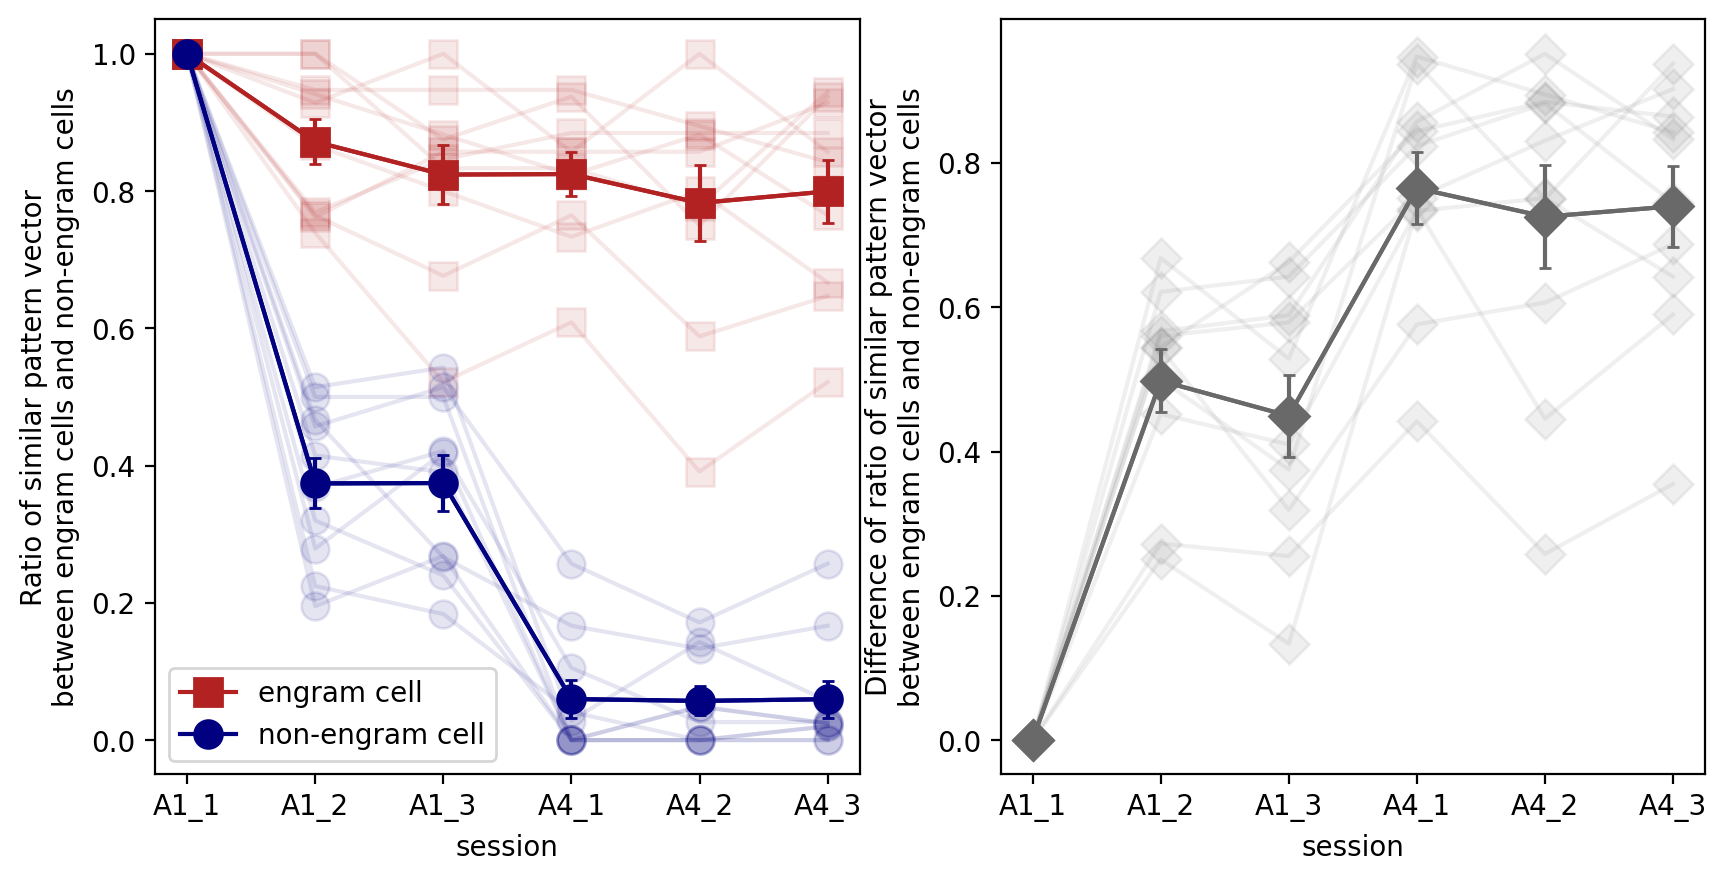

In [9]:
x = engram_matching_score.columns
engram_y, engram_err = engram_matching_score.mean(), engram_matching_score.sem()
non_engram_y, non_engram_err = non_engram_matching_score.mean(), non_engram_matching_score.sem()

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), dpi=200)

axes[0].errorbar(x, engram_y, yerr=engram_err, capsize=2, c='firebrick')
axes[0].plot(x, engram_y, marker='s', markersize=10, label='engram cell', c='firebrick', zorder=12)
axes[0].errorbar(x, non_engram_y, yerr=non_engram_err, capsize=2, c='navy')
axes[0].plot(x, non_engram_y, marker='o', markersize=10, label='non-engram cell', c='navy', zorder=12)

for index, rows in engram_matching_score.iterrows():
    axes[0].plot(x, rows, marker='s', markersize=10, c='firebrick', alpha=0.1)
    
for index, rows in non_engram_matching_score.iterrows():
    axes[0].plot(x, rows, marker='o', markersize=10, c='navy', alpha=0.1)

axes[0].set_xlabel('session')
axes[0].set_ylabel('Ratio of similar pattern vector\nbetween engram cells and non-engram cells')
axes[0].legend()

diffs = engram_matching_score - non_engram_matching_score
diff_mean, diff_err = diffs.mean(), diffs.sem()

axes[1].errorbar(x, diff_mean, yerr=diff_err, capsize=2, c='dimgray')
axes[1].plot(x, diff_mean, marker='D', markersize=10, c='dimgray', zorder=12)

for index, rows in diffs.iterrows():
    axes[1].plot(x, rows, marker='D', markersize=10, c='dimgray', alpha=0.1)
    
axes[1].set_xlabel('session')
axes[1].set_ylabel('Difference of ratio of similar pattern vector\nbetween engram cells and non-engram cells')

fig.show()

In [10]:
columns = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
shuffled_count = 100

matching_score_mcmc_df = pd.DataFrame(index=const.ANIMAL_NAMES, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = a1_csv.data_frame
    a1_matrix = MatrixOptimizer(a1_matrix).divide_sd()
    
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = a4_csv.data_frame
    a4_matrix = MatrixOptimizer(a4_matrix).divide_sd()

    a1_nan_cells = all_nan_cells(a1_matrix)
    a4_nan_cells = all_nan_cells(a4_matrix)
    
    droped_cells = droped_unique_cells(a1_nan_cells, a4_nan_cells)
    a1_matrix.drop(columns=droped_cells, inplace=True)
    a4_matrix.drop(columns=droped_cells, inplace=True)
    
    shuffle_engram_matching_score = pd.DataFrame(index=list(range(shuffled_count)), columns=columns)
    
    for index in range(shuffled_count):
        random_cells = np.random.randint(0, len(a1_matrix.columns), size=len(a1_csv.engram_cells()))
        a1_shuffle_df = a1_matrix.iloc[:, random_cells].copy(deep=True)
        a4_shuffle_df = a4_matrix.iloc[:, random_cells].copy(deep=True)
        
        shuffled_a1_1, shuffled_a1_2, shuffled_a1_3 = split_matrix(a1_shuffle_df, 'A1postES')
        shuffled_a4_1, shuffled_a4_2, shuffled_a4_3 = split_matrix(a4_shuffle_df, 'A4postES')
        
        shuffled_df = {}
        shuffled_df['A1_1'] = shuffled_a1_1
        shuffled_df['A1_2'] = shuffled_a1_2
        shuffled_df['A1_3'] = shuffled_a1_3
        shuffled_df['A4_1'] = shuffled_a4_1
        shuffled_df['A4_2'] = shuffled_a4_2
        shuffled_df['A4_3'] = shuffled_a4_3
        
        shuffled_patterns = {}
        for context_name, df in shuffled_df.items():
            _, H, _ = setted_NMF(df, len(df.columns) - 1)
            shuffled_patterns[context_name] = H

        shuffle_engram_matching_score.loc[index, 'A1_1'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_1'])
        shuffle_engram_matching_score.loc[index, 'A1_2'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_2'])
        shuffle_engram_matching_score.loc[index, 'A1_3'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_3'])
        shuffle_engram_matching_score.loc[index, 'A4_1'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_1'])
        shuffle_engram_matching_score.loc[index, 'A4_2'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_2'])
        shuffle_engram_matching_score.loc[index, 'A4_3'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_3'])
        
    results = mc.resamplings(shuffle_engram_matching_score)
    matching_score_mcmc_df.loc[animal_name, 'A1_1'] = np.mean(results['A1_1'])
    matching_score_mcmc_df.loc[animal_name, 'A1_2'] = np.mean(results['A1_2'])
    matching_score_mcmc_df.loc[animal_name, 'A1_3'] = np.mean(results['A1_3'])
    matching_score_mcmc_df.loc[animal_name, 'A4_1'] = np.mean(results['A4_1'])
    matching_score_mcmc_df.loc[animal_name, 'A4_2'] = np.mean(results['A4_2'])
    matching_score_mcmc_df.loc[animal_name, 'A4_3'] = np.mean(results['A4_3'])
    
matching_score_mcmc_df

animal_name: ID181106CreA


animal_name: ID181106CreB


/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/con

animal_name: ID181106CreC


animal_name: ID181106CreG


animal_name: ID181106CreH


animal_name: ID181106CreI


animal_name: ID181106CreK


/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


animal_name: ID181106CreL


animal_name: ID181106CreN


animal_name: ID181106CreQ


/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
ID181106CreA,1.0,0.696887,0.692216,0.689752,0.636619,0.653011
ID181106CreB,1.0,0.80337,0.805143,0.804666,0.749506,0.72714
ID181106CreC,1.0,0.746645,0.73007,0.708807,0.676112,0.685108
ID181106CreG,1.0,0.623004,0.63005,0.603226,0.6405,0.604111
ID181106CreH,1.0,0.568732,0.539477,0.522269,0.502458,0.449411
ID181106CreI,1.0,0.523215,0.505084,0.452681,0.43541,0.446418
ID181106CreK,1.0,0.752743,0.71064,0.749241,0.73428,0.704252
ID181106CreL,1.0,0.741108,0.704828,0.732713,0.732147,0.685087
ID181106CreN,1.0,0.813628,0.802238,0.720889,0.688814,0.701899
ID181106CreQ,1.0,0.790618,0.788183,0.772935,0.759606,0.755979


In [11]:
matching_score_mcmc_df

,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
ID181106CreA,1.0,0.696887,0.692216,0.689752,0.636619,0.653011
ID181106CreB,1.0,0.80337,0.805143,0.804666,0.749506,0.72714
ID181106CreC,1.0,0.746645,0.73007,0.708807,0.676112,0.685108
ID181106CreG,1.0,0.623004,0.63005,0.603226,0.6405,0.604111
ID181106CreH,1.0,0.568732,0.539477,0.522269,0.502458,0.449411
ID181106CreI,1.0,0.523215,0.505084,0.452681,0.43541,0.446418
ID181106CreK,1.0,0.752743,0.71064,0.749241,0.73428,0.704252
ID181106CreL,1.0,0.741108,0.704828,0.732713,0.732147,0.685087
ID181106CreN,1.0,0.813628,0.802238,0.720889,0.688814,0.701899
ID181106CreQ,1.0,0.790618,0.788183,0.772935,0.759606,0.755979


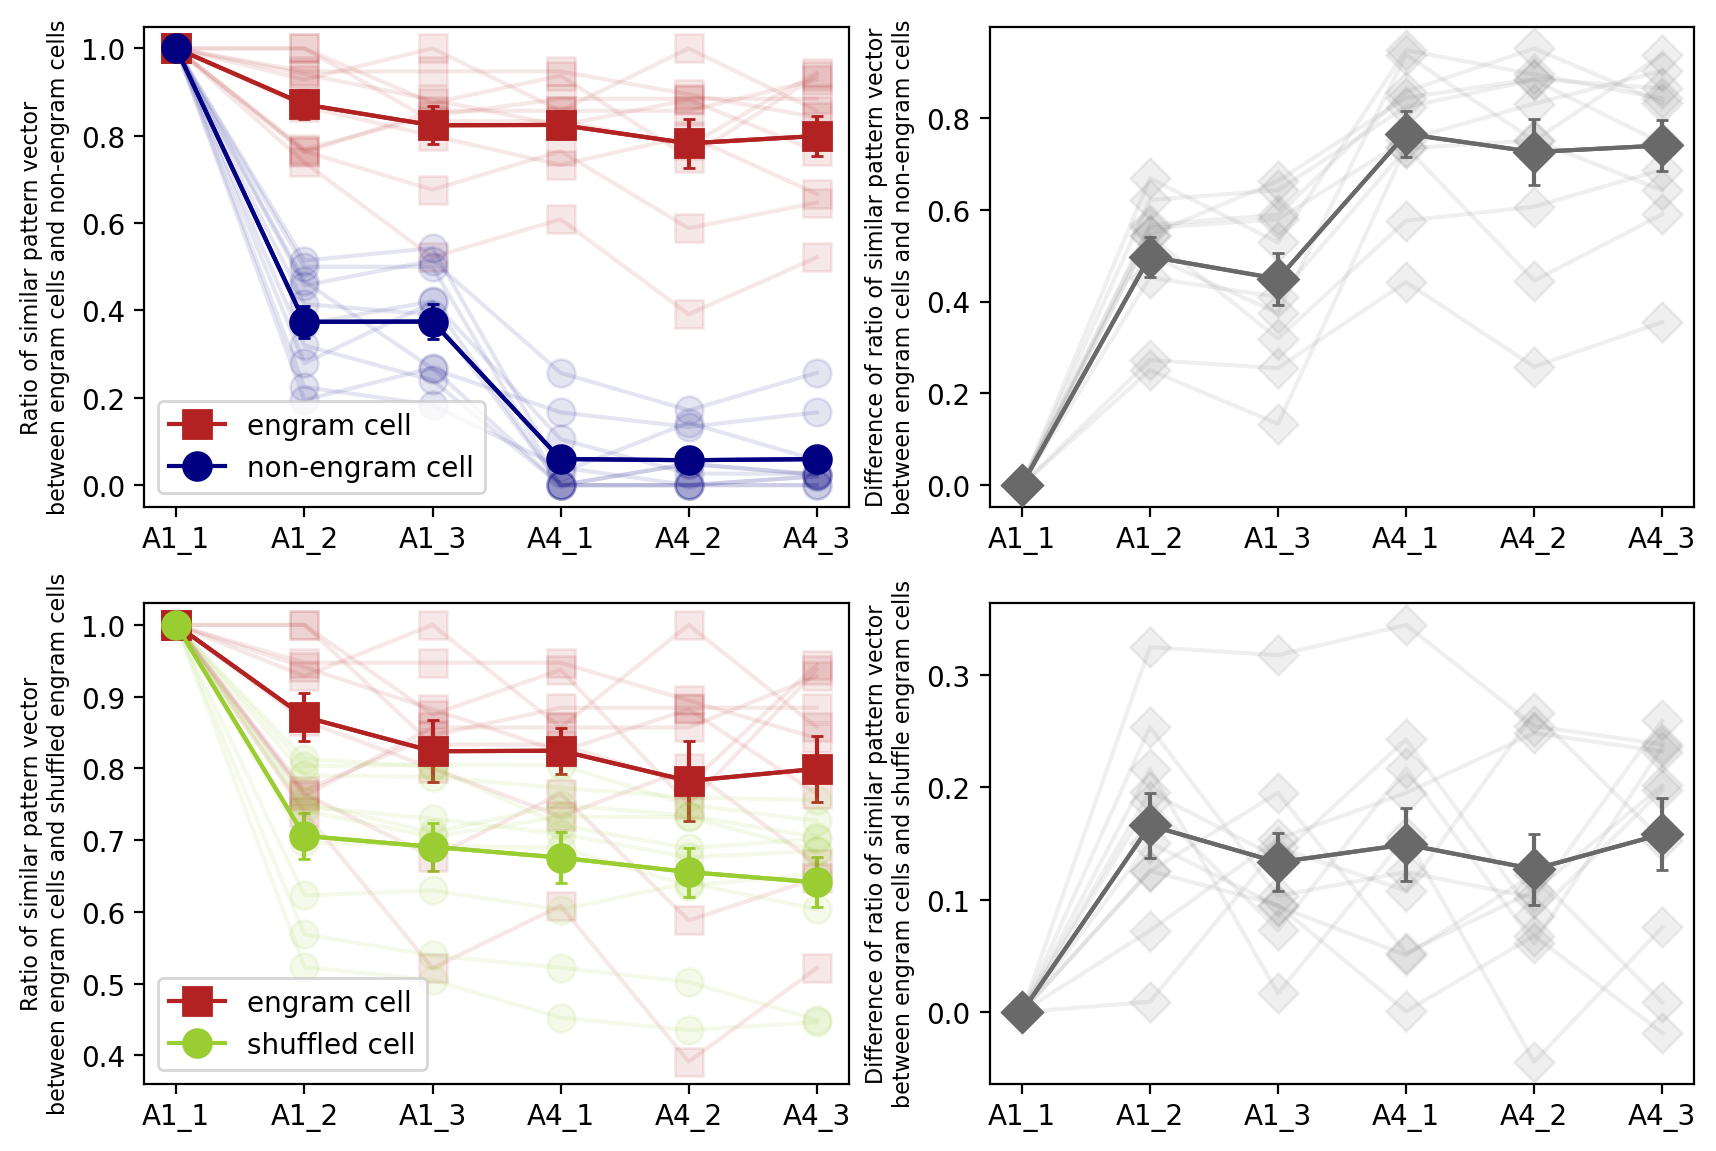

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), dpi=200)

x = engram_matching_score.columns

# mean of MS between engram and non-engram
engram_y, engram_err = engram_matching_score.mean(), engram_matching_score.sem()
non_engram_y, non_engram_err = non_engram_matching_score.mean(), non_engram_matching_score.sem()

axes[0][0].errorbar(x, engram_y, yerr=engram_err, capsize=2, c='firebrick')
axes[0][0].plot(x, engram_y, marker='s', markersize=10, label='engram cell', c='firebrick', zorder=12)
axes[0][0].errorbar(x, non_engram_y, yerr=non_engram_err, capsize=2, c='navy')
axes[0][0].plot(x, non_engram_y, marker='o', markersize=10, label='non-engram cell', c='navy', zorder=12)

for index, rows in engram_matching_score.iterrows():
    axes[0][0].plot(x, rows, marker='s', markersize=10, c='firebrick', alpha=0.1)
    
for index, rows in non_engram_matching_score.iterrows():
    axes[0][0].plot(x, rows, marker='o', markersize=10, c='navy', alpha=0.1)

axes[0][0].set_ylabel('Ratio of similar pattern vector\nbetween engram cells and non-engram cells', fontsize=8)
axes[0][0].legend()

# diff in MS between engram and non-engram
diffs = engram_matching_score - non_engram_matching_score
diff_mean, diff_err = diffs.mean(), diffs.sem()

axes[0][1].errorbar(x, diff_mean, yerr=diff_err, capsize=2, c='dimgray')
axes[0][1].plot(x, diff_mean, marker='D', markersize=10, c='dimgray', zorder=12)

for index, rows in diffs.iterrows():
    axes[0][1].plot(x, rows, marker='D', markersize=10, c='dimgray', alpha=0.1)
    
axes[0][1].set_ylabel('Difference of ratio of similar pattern vector\nbetween engram cells and non-engram cells', fontsize=8)

# mean of MS between engram and shuffled engram
engram_y, engram_err = engram_matching_score.mean(), engram_matching_score.sem()
shuffle_y, shuffle_err = matching_score_mcmc_df.mean(), matching_score_mcmc_df.sem()

axes[1][0].errorbar(x, engram_y, yerr=engram_err, capsize=2, c='firebrick')
axes[1][0].plot(x, engram_y, marker='s', markersize=10, label='engram cell', c='firebrick', zorder=12)
axes[1][0].errorbar(x, shuffle_y, yerr=shuffle_err, capsize=2, c='yellowgreen')
axes[1][0].plot(x, shuffle_y, marker='o', markersize=10, label='shuffled cell', c='yellowgreen', zorder=12)

for index, rows in engram_matching_score.iterrows():
    axes[1][0].plot(x, rows, marker='s', markersize=10, c='firebrick', alpha=0.1)
    
for index, rows in matching_score_mcmc_df.iterrows():
    axes[1][0].plot(x, rows, marker='o', markersize=10, c='yellowgreen', alpha=0.1)
    
axes[1][0].set_ylabel('Ratio of similar pattern vector\nbetween engram cells and shuffled engram cells', fontsize=8)
axes[1][0].legend()

# diff in MS between engram and shuffle engram
diffs = engram_matching_score - matching_score_mcmc_df
diff_mean, diff_err = diffs.mean(), diffs.sem()

axes[1][1].errorbar(x, diff_mean, yerr=diff_err, capsize=2, c='dimgray')
axes[1][1].plot(x, diff_mean, marker='D', markersize=10, c='dimgray', zorder=12)

for index, rows in diffs.iterrows():
    axes[1][1].plot(x, rows, marker='D', markersize=10, c='dimgray', alpha=0.1)
    
axes[1][1].set_ylabel('Difference of ratio of similar pattern vector\nbetween engram cells and shuffle engram cells', fontsize=8)

fig.show()